# Capstone 4

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import sklearn.metrics
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

The data was scraped from a successful online C2C fashion store with over 9M registered users. The store was first launched in Europe around 2009 then expanded worldwide. The data source on Kaggle did not mention the fashion store by name, but my research tells me it's Vestiaire Collective.

Visitors vs Users:
Visitors do not appear in this dataset. Only registered users are included. "Visitors" cannot purchase an article but can view the catalog.

Topic: Speaking as a DA from a VC, I want to explore the data and discover what is driving user retention, and potentially company profit, down. I will then offer meaningful recommendations on how to creatively address these issues.

# Loading and cleaning datasets

In [2]:
# Countries in each dataset written in French. When inspecting on Excel, noticed encryption/accents. Saving to UTF-8,
# and using IFERROR + VLOOKUP to translate country names

In [3]:
# Dealing with encrypted and accented characters:
# Open Excel
# Click “File” and “New”
# Click on the “Data” tab
# Click “From Text” and select the CSV file
# Select “Delimited”
# For “File origin”, select “65001 : Unicode (UTF-8)”
# Click “Next”
# Select “Comma”
# Click “Finish”
# Excel should now show you the CSV file and display the characters correctly.

In [4]:
# Loading revised datasets

In [5]:
pd.set_option('display.max_columns', None)

In [6]:
# Dataset of users and information about their social shopping/behavior

users = pd.read_csv('~/Documents/JONATHANAYALA-CAPSTONE4/DATA/users.csv', encoding='utf8')

users.head(5)

,identifierHash,eng_country,language,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsSold,productsPassRate,productsWished,productsBought,gender,civilityGenderId,civilityTitle,hasAnyApp,hasAndroidApp,hasIosApp,hasProfilePicture,daysSinceLastLogin,seniority,seniorityAsMonths,seniorityAsYears,countryCode
0,-1.097900e+18,United Kingdom,en,147,10,77,26,174,74.0,104,1,M,1,mr,True,False,True,True,11,3196,106.53,8.88,gb
1,2.347570e+18,Monaco,en,167,8,2,19,170,99.0,0,0,F,2,mrs,True,False,True,True,12,3204,106.80,8.90,mc
2,6.870940e+18,France,fr,137,13,60,33,163,94.0,10,3,F,2,mrs,True,False,True,False,11,3203,106.77,8.90,fr
3,-4.640270e+18,United States,en,131,10,14,122,152,92.0,7,0,F,2,mrs,True,False,True,False,12,3198,106.60,8.88,us
4,-5.175830e+18,United States,en,167,8,0,25,125,100.0,0,0,F,2,mrs,False,False,False,True,22,2854,95.13,7.93,us


The users dataset has duplicate columns for seniority. They each reflect the same thing, so I will be using seniorityAsYears, and dropping the other two in a new DataFrame.

civilityTitle is...kind of unhelpful. If I wanted to make a comparison between purchases/sales between single and married persons, it would be interesting. But this is one-sided. I only have insight into whether or not females are married. Dropping column.

civilityGenderID has three categories (one each for title: mr, miss, and mrs). While it's interesting to compare married and unmarried women's buying habits, not having this same information for men is unhelpful. Dropping column.

In [7]:
users_c = users.drop(['civilityTitle', 'civilityGenderId','seniority', 'seniorityAsMonths', 'countryCode'], axis=1)
users_c.head()

,identifierHash,eng_country,language,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsSold,productsPassRate,productsWished,productsBought,gender,hasAnyApp,hasAndroidApp,hasIosApp,hasProfilePicture,daysSinceLastLogin,seniorityAsYears
0,-1.097900e+18,United Kingdom,en,147,10,77,26,174,74.0,104,1,M,True,False,True,True,11,8.88
1,2.347570e+18,Monaco,en,167,8,2,19,170,99.0,0,0,F,True,False,True,True,12,8.90
2,6.870940e+18,France,fr,137,13,60,33,163,94.0,10,3,F,True,False,True,False,11,8.90
3,-4.640270e+18,United States,en,131,10,14,122,152,92.0,7,0,F,True,False,True,False,12,8.88
4,-5.175830e+18,United States,en,167,8,0,25,125,100.0,0,0,F,False,False,False,True,22,7.93


How many of these users are actually active, whether they're buying, selling, or interacting?
There are a couple ways to filter this. A completely inactive user will have no social engagement,
purchases made/products wishlisted, or sales made/products on offer. Let's get rid of these first.

NOTE: New users are given follower/following by default.

Creating new df for active users, to be further segmented into prospective buyers and sellers (active, but 
may not have landed a sale/purchase yet, for whatever reason).

In [8]:
# Columns to determine active user status:
# socialProductsLiked, productsListed, productsSold, productsPassRate, productsWished, productsBought

In [9]:
# Mask to view inactive users
inactive_u = users_c[((users_c['socialProductsLiked'] == 0)) & ((users_c['productsListed'] == 0)) & ((users_c['productsSold'] == 0)) & ((users_c['productsWished'] == 0)) & ((users_c['productsBought'] == 0))]
inactive_u

,identifierHash,eng_country,language,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsSold,productsPassRate,productsWished,productsBought,gender,hasAnyApp,hasAndroidApp,hasIosApp,hasProfilePicture,daysSinceLastLogin,seniorityAsYears
2087,-6.195860e+18,United States,en,28,8,0,0,0,0.0,0,0,F,True,False,True,False,370,8.90
2107,5.919340e+18,France,fr,25,8,0,0,0,0.0,0,0,F,False,False,False,False,611,8.89
2201,6.579880e+18,Finland,en,17,11,0,0,0,0.0,0,0,F,False,False,False,True,694,7.94
2239,1.502230e+18,United States,en,15,13,0,0,0,0.0,0,0,F,False,False,False,True,594,8.88
2247,7.798470e+17,Germany,de,15,12,0,0,0,0.0,0,0,F,True,False,True,True,480,8.90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98908,-5.324380e+18,No Country Found,fr,3,8,0,0,0,0.0,0,0,M,False,False,False,True,708,8.90
98909,-5.607670e+18,No Country Found,fr,3,8,0,0,0,0.0,0,0,M,True,False,True,True,695,8.90
98910,3.506300e+17,No Country Found,en,3,8,0,0,0,0.0,0,0,M,True,True,False,True,520,8.90
98911,2.006580e+18,No Country Found,it,3,8,0,0,0,0.0,0,0,F,False,False,False,True,267,8.90


In [10]:
# Using excel to create csv for active users, but hang on to inactive_u just in case you want some insights
# on inactive users.
# users_c.to_csv('active_clean.csv')

In [11]:
# Load active user dataset. This will be the primary focus of the analysis.
active_clean = pd.read_csv('~/Documents/JONATHANAYALA-CAPSTONE4/DATA/active_clean.csv', encoding='utf8')
active_clean

,identifierHash,eng_country,language,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsSold,productsPassRate,productsWished,productsBought,gender,hasAnyApp,hasAndroidApp,hasIosApp,hasProfilePicture,daysSinceLastLogin,seniorityAsYears
0,-1.100000e+18,United Kingdom,en,147,10,77,26,174,74.0,104,1,M,True,False,True,True,11,8.88
1,2.350000e+18,Monaco,en,167,8,2,19,170,99.0,0,0,F,True,False,True,True,12,8.90
2,6.870000e+18,France,fr,137,13,60,33,163,94.0,10,3,F,True,False,True,False,11,8.90
3,-4.640000e+18,United States,en,131,10,14,122,152,92.0,7,0,F,True,False,True,False,12,8.88
4,-5.180000e+18,United States,en,167,8,0,25,125,100.0,0,0,F,False,False,False,True,22,7.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21634,4.510000e+18,No Country Found,fr,3,8,1,0,0,0.0,4,0,F,False,False,False,True,477,8.90
21635,4.720000e+18,No Country Found,en,3,8,10,0,0,0.0,0,0,F,True,False,True,True,15,8.90
21636,8.400000e+17,No Country Found,fr,3,8,5,0,0,0.0,2,5,F,False,False,False,True,192,8.90
21637,7.260000e+18,No Country Found,es,3,8,31,0,0,0.0,0,0,F,False,False,False,True,13,8.90


In [12]:
# Comparison of seller accounts by country and gender

sellers = pd.read_csv('~/Documents/JONATHANAYALA-CAPSTONE4/DATA/sellers.csv', encoding='utf8')

sellers.head(5)

,eng_country,sex,nbsellers,meanproductssold,meanproductslisted,meansellerpassrate,totalproductssold,totalproductslisted,meanproductsbought,meanproductswished,meanproductsliked,totalbought,totalwished,totalproductsliked,meanfollowers,meanfollows,percentofappusers,percentofiosusers,meanseniority
0,Germany,Female,116,4.03,2.72,27.33,468,315,3.05,34.66,35.28,354,4021,4092,9.5,8.9,54.0,49.0,3060.336207
1,Germany,Male,34,2.00,1.00,19.15,68,34,1.62,3.38,31.79,55,115,1081,7.8,8.4,79.0,64.0,3089.058824
2,Armenia,Female,1,0.00,25.00,0.00,0,25,0.00,0.00,1.00,0,0,1,4.0,8.0,NaN,NaN,3201.000000
3,Australia,Female,18,0.94,1.33,10.44,17,24,6.11,17.72,209.28,110,319,3767,7.5,9.3,55.0,55.0,3103.666667
4,Australia,Male,3,6.00,4.00,33.33,18,12,8.00,24.00,38.33,24,72,115,12.7,8.3,66.0,66.0,3085.666667


In [13]:
# Stats about countries with top sellers. Top sellers those with >= 20 products sold
# They represent ~ the top 10% of all seller accounts in the dataset
# (Seller accounts are those who successfully sold at least 1 product)
# These are just insights extracted from the main file!

# Note: incl. countries list only 1 top seller each.

topsellers = pd.read_csv('~/Documents/JONATHANAYALA-CAPSTONE4/DATA/topsellers.csv', encoding='utf8')

topsellers

,eng_country,sellers,topsellers,topsellerratio,femalesellersratio,topfemalesellersratio,femalesellers,malesellers,topfemalesellers,topmalesellers,countrysoldratio,bestsoldratio,toptotalproductssold,totalproductssold,toptotalproductslisted,totalproductslisted,topmeanproductssold,topmeanproductslisted,meanproductssold,meanproductslisted,meanofflinedays,topmeanofflinedays,meanfollowers,meanfollowing,topmeanfollowers,topmeanfollowing
0,Taiwan,1,1,100.0,100.0,100.0,1,0,1,0,1.02,1.02,57,57,56,56,57.000000,56.000000,57.000000,56.000000,11.0,11.0,83.0,8.0,83.0,8.0
1,Slovakia,2,1,50.0,0.0,0.0,0,2,0,1,2.00,1.93,27,28,14,14,27.000000,14.000000,14.000000,7.000000,17.0,15.0,10.5,8.5,15.0,8.0
2,Latvia,4,2,50.0,100.0,100.0,4,0,2,0,2.31,2.25,81,83,36,36,40.500000,18.000000,20.750000,9.000000,120.3,11.5,21.0,52.3,38.0,98.5
3,Bulgaria,9,4,44.4,66.7,100.0,6,3,4,0,2.07,2.10,145,170,69,82,36.250000,17.250000,18.888889,9.111111,98.3,19.0,28.6,31.6,46.3,19.0
4,Cyprus,4,1,25.0,100.0,100.0,4,0,1,0,0.69,0.62,41,56,66,81,41.000000,66.000000,14.000000,20.250000,17.3,11.0,21.3,10.3,39.0,17.0
5,Monaco,5,1,20.0,100.0,100.0,5,0,1,0,7.31,8.95,170,190,19,26,170.000000,19.000000,38.000000,5.200000,51.6,12.0,39.6,8.0,167.0,8.0
6,Romania,13,2,15.4,76.9,50.0,10,3,1,1,0.88,1.26,49,68,39,77,24.500000,19.500000,5.230769,5.923077,121.6,11.0,10.9,11.5,30.0,32.0
7,Luxembourg,7,1,14.3,85.7,100.0,6,1,1,0,5.38,NaN,30,43,0,8,30.000000,0.000000,6.142857,1.142857,73.6,11.0,15.9,8.4,52.0,3.0
8,Spain,119,13,10.9,81.5,76.9,97,22,10,3,1.67,2.02,607,990,301,594,46.692308,23.153846,8.319328,4.991597,202.4,30.5,16.1,14.6,53.2,14.5
9,Italy,347,35,10.1,71.5,65.7,248,99,23,12,1.27,1.29,1389,2820,1077,2218,39.685714,30.771429,8.126801,6.391931,141.8,26.5,16.1,54.6,63.4,429.3


# EDA

In [14]:
# active_clean

In [15]:
active_clean.shape

(21639, 18)

In [16]:
active_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21639 entries, 0 to 21638
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   identifierHash       21639 non-null  float64
 1   eng_country          21639 non-null  object 
 2   language             21639 non-null  object 
 3   socialNbFollowers    21639 non-null  int64  
 4   socialNbFollows      21639 non-null  int64  
 5   socialProductsLiked  21639 non-null  int64  
 6   productsListed       21639 non-null  int64  
 7   productsSold         21639 non-null  int64  
 8   productsPassRate     21639 non-null  float64
 9   productsWished       21639 non-null  int64  
 10  productsBought       21639 non-null  int64  
 11  gender               21639 non-null  object 
 12  hasAnyApp            21639 non-null  bool   
 13  hasAndroidApp        21639 non-null  bool   
 14  hasIosApp            21639 non-null  bool   
 15  hasProfilePicture    21639 non-null 

In [17]:
active_clean.describe()

,identifierHash,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsSold,productsPassRate,productsWished,productsBought,daysSinceLastLogin,seniorityAsYears
count,2.163900e+04,21639.000000,21639.000000,21639.000000,21639.000000,21639.000000,21639.000000,21639.000000,21639.000000,21639.000000,21639.000000
mean,3.526222e+16,4.557558,9.911271,20.207450,0.426498,0.555802,3.713078,7.142705,0.785896,384.445631,8.510885
std,5.329057e+18,8.155680,112.960063,386.638353,4.367049,4.520774,17.874985,53.491932,4.937857,271.408591,0.467789
min,-9.220000e+18,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,7.920000
25%,-4.540000e+18,3.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,87.000000,7.940000
50%,6.320000e+16,3.000000,8.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,401.000000,8.880000
75%,4.630000e+18,4.000000,8.000000,6.000000,0.000000,0.000000,0.000000,2.000000,1.000000,680.000000,8.890000
max,9.220000e+18,744.000000,13764.000000,51671.000000,244.000000,174.000000,100.000000,2635.000000,405.000000,709.000000,8.900000


In [18]:
# How many products were sold in total from this group?
active_clean['productsSold'].sum()

12027

In [19]:
# How many products bought?
active_clean['productsBought'].sum()

17006

In [20]:
# How many people have an app installed?
active_clean['hasAnyApp'].value_counts()

False    11618
True     10021
Name: hasAnyApp, dtype: int64

In [21]:
# How many people have an Android app installed?
active_clean['hasAndroidApp'].value_counts()

False    20086
True      1553
Name: hasAndroidApp, dtype: int64

In [22]:
# How many people have an Ios app installed?
active_clean['hasIosApp'].value_counts()

False    13038
True      8601
Name: hasIosApp, dtype: int64

53.7% of active users don't have the fashion store app installed (21639 total). Of the 46.3% who do have an app installed, 7.2% have the Android App, and 39.7% have the Ios App installed. But does the app have any true impact on the total sales made?

In [23]:
has_app = active_clean[active_clean['hasAnyApp'] == True]
has_app

,identifierHash,eng_country,language,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsSold,productsPassRate,productsWished,productsBought,gender,hasAnyApp,hasAndroidApp,hasIosApp,hasProfilePicture,daysSinceLastLogin,seniorityAsYears
0,-1.100000e+18,United Kingdom,en,147,10,77,26,174,74.0,104,1,M,True,False,True,True,11,8.88
1,2.350000e+18,Monaco,en,167,8,2,19,170,99.0,0,0,F,True,False,True,True,12,8.90
2,6.870000e+18,France,fr,137,13,60,33,163,94.0,10,3,F,True,False,True,False,11,8.90
3,-4.640000e+18,United States,en,131,10,14,122,152,92.0,7,0,F,True,False,True,False,12,8.88
5,7.630000e+18,Germany,de,130,12,1,47,123,91.0,0,0,F,True,False,True,False,11,8.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21626,-7.390000e+18,United Kingdom,en,3,8,0,0,0,0.0,1,0,F,True,False,True,True,443,8.90
21627,-7.160000e+18,France,fr,3,9,0,0,0,0.0,0,1,F,True,True,False,True,429,8.90
21632,7.950000e+18,France,fr,3,8,22,0,0,0.0,0,0,F,True,False,True,True,678,8.90
21633,3.430000e+18,Germany,de,3,8,1,0,0,0.0,0,0,F,True,False,True,True,176,8.90


In [24]:
no_app = active_clean[active_clean['hasAnyApp'] == False]

In [25]:
no_app['productsSold'].sum()

3233

In [26]:
no_app['productsBought'].sum()

7957

In [27]:
has_app['productsSold'].sum()

8794

In [28]:
has_app['productsBought'].sum()

9049

In the active users group, 12,027 products were sold, and 17,006 were bought. Approximately 73% of those sold items and 53.2% of the products bought were from those active users with the app installed. Whether those purchases were made on the app, however, is a mystery. Adding this as a shortcoming of the dataset. 

Interestingly though, more products were bought and sold by those who had the app installed compared to those with no app. This could speak to the impact of the social aspect Vestiaire prides themself on.

In [29]:
has_ios = active_clean[active_clean['hasIosApp'] == True]
has_ios

,identifierHash,eng_country,language,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsSold,productsPassRate,productsWished,productsBought,gender,hasAnyApp,hasAndroidApp,hasIosApp,hasProfilePicture,daysSinceLastLogin,seniorityAsYears
0,-1.100000e+18,United Kingdom,en,147,10,77,26,174,74.0,104,1,M,True,False,True,True,11,8.88
1,2.350000e+18,Monaco,en,167,8,2,19,170,99.0,0,0,F,True,False,True,True,12,8.90
2,6.870000e+18,France,fr,137,13,60,33,163,94.0,10,3,F,True,False,True,False,11,8.90
3,-4.640000e+18,United States,en,131,10,14,122,152,92.0,7,0,F,True,False,True,False,12,8.88
5,7.630000e+18,Germany,de,130,12,1,47,123,91.0,0,0,F,True,False,True,False,11,8.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21623,6.910000e+18,Sweden,en,3,8,24,0,0,0.0,0,0,F,True,False,True,True,346,8.90
21626,-7.390000e+18,United Kingdom,en,3,8,0,0,0,0.0,1,0,F,True,False,True,True,443,8.90
21632,7.950000e+18,France,fr,3,8,22,0,0,0.0,0,0,F,True,False,True,True,678,8.90
21633,3.430000e+18,Germany,de,3,8,1,0,0,0.0,0,0,F,True,False,True,True,176,8.90


In [30]:
has_ios['productsSold'].sum()

7727

In [31]:
has_ios['productsBought'].sum()

7668

In [32]:
has_android = active_clean[active_clean['hasAndroidApp'] == True]
has_android

,identifierHash,eng_country,language,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsSold,productsPassRate,productsWished,productsBought,gender,hasAnyApp,hasAndroidApp,hasIosApp,hasProfilePicture,daysSinceLastLogin,seniorityAsYears
6,6.740000e+17,Sweden,en,121,0,1140,31,108,94.0,531,105,F,True,True,False,False,11,8.88
19,8.740000e+18,Spain,es,85,0,115,54,73,90.0,4,0,M,True,True,False,False,11,8.89
29,7.930000e+18,Italy,it,47,8,4,9,63,98.0,1,0,F,True,True,False,True,12,7.94
40,2.060000e+18,Italy,it,63,8,2,7,49,86.4,0,0,F,True,True,False,False,12,8.89
45,6.320000e+18,France,fr,22,8,0,2,44,89.1,0,0,F,True,True,False,True,11,8.89
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21591,-6.320000e+18,Italy,it,3,8,2,0,0,0.0,0,0,F,True,True,False,True,225,8.90
21613,-8.120000e+18,France,en,3,8,3,0,0,0.0,7,0,F,True,True,False,True,704,8.90
21619,1.980000e+16,Switzerland,de,3,8,4,0,0,0.0,0,0,F,True,True,False,True,603,8.90
21625,1.930000e+18,United States,en,3,8,8,0,0,0.0,0,0,F,True,True,False,True,541,8.90


In [33]:
has_android['productsSold'].sum()

1299

In [34]:
has_android['productsBought'].sum()

1778

Of those who have an app installed (8,794 products sold and 9,049 products bought), 87.9% of those products sold were from IOS users, and 84.7% (or 85%) of products bought were also from IOS users. In other words, if these purchases and sales were made via app, we see that most business is done via IOS. We don't have any further data on app usage, size, optimization, or even app-store reviews. However, if these transactions WERE made via the app, we should definitely focus on the app experience being as smooth and convenient for our users as possible, since a good portion of the total sales would come from the app.

Transactions by non-app users: 11,190 (37.7%)
Transactions by IOS app users: 15,395 (51.9%)
Transactions by Android app users: 3,077 (10.4%)
Total: 29,662 (slightly overstated compared to earlier observation, could be the distinction between the hasApp boolean. Difference minor, but the proportionality of this graph should be accurate)

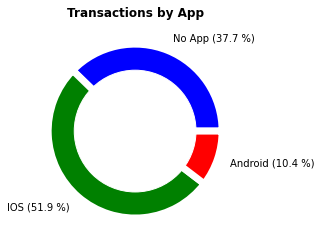

In [35]:
# Donut chart reflecting breakdown of total transactions by app installed
names=[r'No App (37.7 %)', r'IOS (51.9 %)', 
r'Android (10.4 %)']
size=[11190,15395,3077]
 
# Create a circle for the center of the plot
my_circle=plt.Circle( (0,0), 0.7, color='white')


plt.rcParams['text.color'] = 'black'
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.pie(size, labels=names, colors=['blue','green','red'], labeldistance=1.15, 
        wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Transactions by App', fontweight='bold')

# plt.savefig('donut.png', dpi=100)

plt.show()

Text(0.5, 1.0, 'Days Since Last Login')

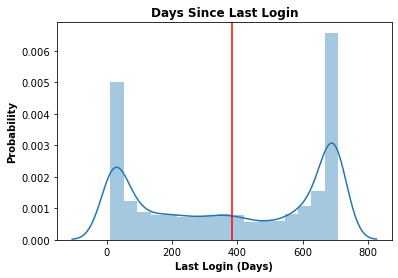

In [36]:
# Distribution of daysSinceLastLogin
# sns.set(rc={'figure.figsize': (16,3)})

x = active_clean['daysSinceLastLogin'].values

mean = active_clean['daysSinceLastLogin'].mean()

sns.distplot(x)

plt.axvline(mean,0, 1, color = 'red')

plt.xlabel('Last Login (Days)', fontweight='bold')
plt.ylabel('Probability', fontweight='bold')
plt.title('Days Since Last Login', fontweight='bold')

# plt.savefig('dayslastlogin_gen.png')

While the average amount of days for the more active users since last login is 384 days (which is still a lot), there's an even greater probability that a given user has last logged in ~700 days ago. This needs to come WAY down. It's almost like you're most likely to be either really active or really inactive. We should bring the really inactive numbers down. Let's look at these greater cases.

Text(0.5, 1.0, 'Days Since Last Login for Non-App Users')

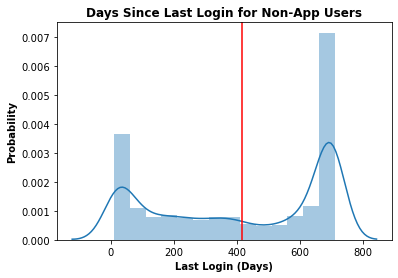

In [37]:
# Days since last login for active user WITHOUT an app installed
noappactivity = active_clean[active_clean['hasAnyApp'] == False]

x = noappactivity['daysSinceLastLogin'].values

mean = noappactivity['daysSinceLastLogin'].mean()

sns.distplot(x)

plt.axvline(mean,0, 1, color = 'red')

plt.xlabel('Last Login (Days)', fontweight='bold')
plt.ylabel('Probability', fontweight='bold')
plt.title('Days Since Last Login for Non-App Users', fontweight='bold')

# plt.savefig('dayslastlogin_noapp.png')

In [38]:
noappactivity['daysSinceLastLogin'].mean()

414.7491823033224

Text(0.5, 1.0, 'Days Since Last Login for App Users')

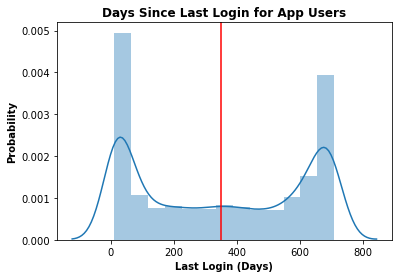

In [39]:
# Days since last login for active users WITH an app installed
yesappactivity = active_clean[active_clean['hasAnyApp'] == True]

x = yesappactivity['daysSinceLastLogin'].values

mean = yesappactivity['daysSinceLastLogin'].mean()

sns.distplot(x)

plt.axvline(mean,0, 1, color = 'red')

plt.xlabel('Last Login (Days)', fontweight='bold')
plt.ylabel('Probability', fontweight='bold')
plt.title('Days Since Last Login for App Users', fontweight='bold')

# plt.savefig('dayslastlogin_app.png')

In [40]:
yesappactivity['daysSinceLastLogin'].mean()

349.3127432391977

In [41]:
wya = active_clean[active_clean['daysSinceLastLogin'] > mean]
wya

,identifierHash,eng_country,language,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsSold,productsPassRate,productsWished,productsBought,gender,hasAnyApp,hasAndroidApp,hasIosApp,hasProfilePicture,daysSinceLastLogin,seniorityAsYears
117,-1.840000e+18,France,fr,15,8,0,2,21,80.0,0,0,F,False,False,False,True,509,7.94
120,7.600000e+18,Italy,it,37,8,3,0,20,90.0,0,0,M,True,True,False,True,407,7.94
130,2.090000e+18,Belgium,fr,19,8,0,1,19,50.0,0,0,F,True,False,True,True,462,8.88
151,-3.280000e+18,France,fr,22,8,0,27,16,100.0,0,0,F,False,False,False,True,653,8.90
160,-2.480000e+18,France,fr,35,89,35,2,15,60.0,2,0,M,True,False,True,False,385,8.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21630,-5.640000e+18,Italy,it,3,8,0,0,0,0.0,4,0,F,False,False,False,True,708,8.90
21631,4.050000e+18,France,fr,3,8,9,0,0,0.0,0,0,F,False,False,False,True,708,8.90
21632,7.950000e+18,France,fr,3,8,22,0,0,0.0,0,0,F,True,False,True,True,678,8.90
21634,4.510000e+18,No Country Found,fr,3,8,1,0,0,0.0,4,0,F,False,False,False,True,477,8.90


In [42]:
wya_sales = active_clean[(active_clean['daysSinceLastLogin'] > mean) & (active_clean['productsSold'] == 0) & (active_clean['productsBought'] == 0)]
wya_sales

,identifierHash,eng_country,language,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsSold,productsPassRate,productsWished,productsBought,gender,hasAnyApp,hasAndroidApp,hasIosApp,hasProfilePicture,daysSinceLastLogin,seniorityAsYears
2053,9.020000e+18,United States,en,31,8,7,0,0,0.0,0,0,F,True,False,True,False,677,8.9
2054,-1.100000e+18,Canada,fr,31,9,594,0,0,0.0,57,0,F,False,False,False,False,633,8.9
2055,9.130000e+18,Hong Kong,en,31,8,6,0,0,0.0,0,0,F,True,False,True,False,647,8.9
2058,-2.000000e+18,Portugal,en,30,9,5,0,0,0.0,3,0,F,False,False,False,False,606,8.9
2060,-6.830000e+18,Germany,de,30,8,1,1,0,0.0,12,0,F,True,False,True,False,394,8.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21630,-5.640000e+18,Italy,it,3,8,0,0,0,0.0,4,0,F,False,False,False,True,708,8.9
21631,4.050000e+18,France,fr,3,8,9,0,0,0.0,0,0,F,False,False,False,True,708,8.9
21632,7.950000e+18,France,fr,3,8,22,0,0,0.0,0,0,F,True,False,True,True,678,8.9
21634,4.510000e+18,No Country Found,fr,3,8,1,0,0,0.0,4,0,F,False,False,False,True,477,8.9


11,110 users (51.3% of total "active" users) have been offline for an above-average amount of time. 8,732 (78.6%) of this subset of user data haven't bought or sold anything during this time period. This further reinforces that the site needs to do more to keep people engaged. Even though there is SOME activity on their accounts, we need to bring them back, and keep them back. They could have signed up just to window shop. Maybe they don't feel they can afford these luxury items. Perhaps new users and those who refer friends can be eligible for discounts on hot items.

In [43]:
# Breakdown of users by spoken language
grouped = active_clean.groupby(users_c['language'])['identifierHash'].count().reset_index()
grouped.sort_values('identifierHash', ascending=False)

# (21639 total) 51.5% of users speak English, 26.6% French, 8.5% Italian, 7.6% German, and 5.8% Spanish

,language,identifierHash
1,en,11157
3,fr,5748
4,it,1836
0,de,1653
2,es,1245


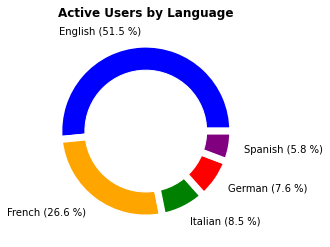

In [44]:
# Donut chart reflecting breakdown of users by spoken language
names=[r'English (51.5 %)', r'French (26.6 %)', 
r'Italian (8.5 %)', r'German (7.6 %)', r'Spanish (5.8 %)']
size=[11157,5748,1836,1653,1245]
 
# Create a circle for the center of the plot
my_circle=plt.Circle( (0,0), 0.7, color='white')


plt.rcParams['text.color'] = 'black'
fig = plt.figure()
fig.patch.set_facecolor('white')

plt.pie(size, labels=names, colors=['blue','orange','green','red','purple'], labeldistance=1.15, 
        wedgeprops = { 'linewidth' : 7, 'edgecolor' : 'white' })
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.title('Active Users by Language', fontweight='bold')

# plt.savefig('donut.png', dpi=100)

plt.show()

<AxesSubplot:xlabel='language', ylabel='count'>

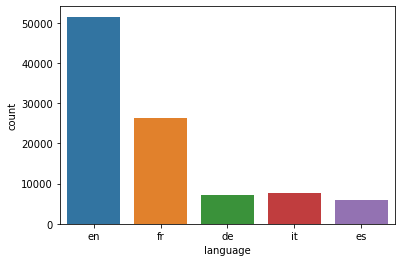

In [45]:
sns.countplot(users_c['language'])

In other words, more than half of all users of Vestiaire Collective are English speakers.

In [46]:
# Breakdown of users by gender
active_clean.groupby(active_clean['gender'])['identifierHash'].count()

gender
F    17392
M     4247
Name: identifierHash, dtype: int64

<AxesSubplot:xlabel='gender', ylabel='count'>

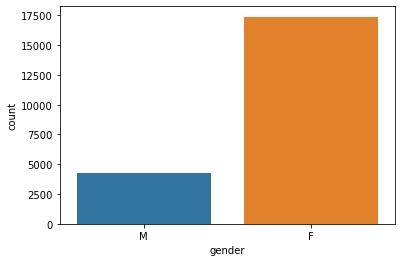

In [47]:
sns.countplot(active_clean['gender'])

An overwhelming majority (80%) of all active users are female.

In [48]:
# Further segment the data. Who are the sellers? Who are the buyers?

In [49]:
# Total prospective sellers (> 0 productsListed, so you know they're trying to sell)

In [50]:
p_sellers = active_clean[(active_clean['productsListed'] > 0) | (active_clean['productsSold'] > 0)]
p_sellers

,identifierHash,eng_country,language,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsSold,productsPassRate,productsWished,productsBought,gender,hasAnyApp,hasAndroidApp,hasIosApp,hasProfilePicture,daysSinceLastLogin,seniorityAsYears
0,-1.100000e+18,United Kingdom,en,147,10,77,26,174,74.0,104,1,M,True,False,True,True,11,8.88
1,2.350000e+18,Monaco,en,167,8,2,19,170,99.0,0,0,F,True,False,True,True,12,8.90
2,6.870000e+18,France,fr,137,13,60,33,163,94.0,10,3,F,True,False,True,False,11,8.90
3,-4.640000e+18,United States,en,131,10,14,122,152,92.0,7,0,F,True,False,True,False,12,8.88
4,-5.180000e+18,United States,en,167,8,0,25,125,100.0,0,0,F,False,False,False,True,22,7.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21180,1.740000e+18,France,fr,3,8,1,1,0,0.0,0,1,F,False,False,False,True,11,8.90
21232,8.620000e+18,Italy,it,3,8,0,2,0,0.0,5,2,F,False,False,False,True,229,8.90
21269,-7.550000e+18,Spain,es,3,8,1,1,0,0.0,0,0,M,True,False,True,False,42,8.90
21509,-3.770000e+16,France,fr,3,8,58,3,0,0.0,7,1,F,False,False,False,True,11,8.90


With 2719 prospective sellers, we can subtract that from the total # of active users to see that there are 18,920 prospective buyers.

In [51]:
# Total successful buyers and sellers (>= 1 purchase/sale made)

In [52]:
buyers = active_clean[active_clean['productsBought'] >= 1]
buyers

,identifierHash,eng_country,language,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsSold,productsPassRate,productsWished,productsBought,gender,hasAnyApp,hasAndroidApp,hasIosApp,hasProfilePicture,daysSinceLastLogin,seniorityAsYears
0,-1.100000e+18,United Kingdom,en,147,10,77,26,174,74.0,104,1,M,True,False,True,True,11,8.88
2,6.870000e+18,France,fr,137,13,60,33,163,94.0,10,3,F,True,False,True,False,11,8.90
6,6.740000e+17,Sweden,en,121,0,1140,31,108,94.0,531,105,F,True,True,False,False,11,8.88
9,3.910000e+18,United Kingdom,en,57,8,45,123,92,74.0,6,2,F,True,False,True,True,11,7.93
12,-6.040000e+18,Spain,es,46,19,1308,63,87,92.0,564,36,F,True,False,True,True,11,8.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21605,-4.440000e+18,Sweden,en,3,8,1,0,0,0.0,0,1,M,True,False,True,True,62,8.90
21606,4.750000e+18,Hungary,en,3,8,9,0,0,0.0,29,1,F,False,False,False,True,23,8.90
21620,-8.570000e+17,United Kingdom,en,3,8,178,0,0,0.0,7,2,F,False,False,False,True,14,8.90
21627,-7.160000e+18,France,fr,3,9,0,0,0,0.0,0,1,F,True,True,False,True,429,8.90


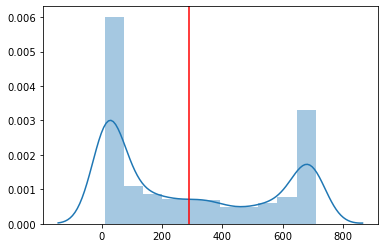

In [53]:
# Distribution of days since last login for users who have made at least one purchase

x = buyers['daysSinceLastLogin'].values

mean = buyers['daysSinceLastLogin'].mean()

sns.distplot(x)

plt.axvline(mean,0, 1, color = 'red')

Most users who make at least one purchase are more likely to be more active, but there is still a strong possibility that they may make one purchase and become inactive. 

In [54]:
sellers = active_clean[active_clean['productsSold'] >= 1]
sellers

,identifierHash,eng_country,language,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsSold,productsPassRate,productsWished,productsBought,gender,hasAnyApp,hasAndroidApp,hasIosApp,hasProfilePicture,daysSinceLastLogin,seniorityAsYears
0,-1.100000e+18,United Kingdom,en,147,10,77,26,174,74.0,104,1,M,True,False,True,True,11,8.88
1,2.350000e+18,Monaco,en,167,8,2,19,170,99.0,0,0,F,True,False,True,True,12,8.90
2,6.870000e+18,France,fr,137,13,60,33,163,94.0,10,3,F,True,False,True,False,11,8.90
3,-4.640000e+18,United States,en,131,10,14,122,152,92.0,7,0,F,True,False,True,False,12,8.88
4,-5.180000e+18,United States,en,167,8,0,25,125,100.0,0,0,F,False,False,False,True,22,7.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2031,1.030000e+18,Switzerland,en,3,8,7,0,1,0.0,1,0,F,True,False,True,True,13,8.90
2032,-6.310000e+18,Italy,it,3,9,0,0,1,0.0,0,0,M,True,False,True,False,323,8.90
2033,-5.900000e+17,France,fr,3,8,0,1,1,0.0,0,0,F,False,False,False,True,244,8.90
2034,8.090000e+18,France,fr,3,8,0,1,1,0.0,0,0,M,False,False,False,True,133,8.90


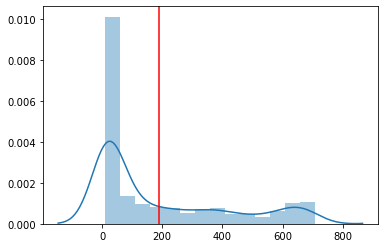

In [55]:
# Distribution of days since last login for sellers who have made at least one sale

x = sellers['daysSinceLastLogin'].values

mean = sellers['daysSinceLastLogin'].mean()

sns.distplot(x)

plt.axvline(mean,0, 1, color = 'red')

Sellers who make at least one sale are more likely to login more frequently.

In [56]:
app_query = sellers.groupby(['hasAnyApp'])['socialNbFollowers'].sum().reset_index()
app_query

,hasAnyApp,socialNbFollowers
0,False,6095
1,True,18029


In [57]:
app_query2 = sellers.groupby(['hasAnyApp'])['socialNbFollowers'].mean().reset_index()
app_query2

,hasAnyApp,socialNbFollowers
0,False,8.148396
1,True,13.997671


As we can see, sellers who use an app are more likely to have a greater amount of followers than those without an app installed.

Text(0.5, 1.0, 'Total Followers, No App vs App')

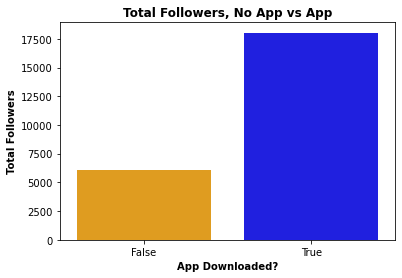

In [58]:
# Visualizing this comparison
ax = sns.barplot(x = 'hasAnyApp', y = 'socialNbFollowers', data = app_query, palette = ["orange", "blue"], ci = False)

plt.xlabel('App Downloaded?', fontweight='bold')
plt.ylabel('Total Followers', fontweight='bold')
plt.title('Total Followers, No App vs App', fontweight='bold')

Text(0.5, 1.0, 'Avg Followers, No App vs App')

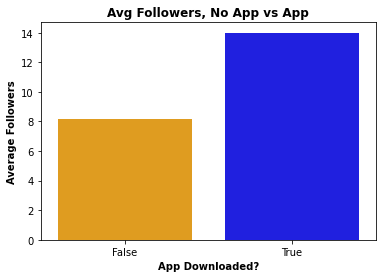

In [59]:
ax = sns.barplot(x = 'hasAnyApp', y = 'socialNbFollowers', data = app_query2, palette = ["orange", "blue"], ci = False)

plt.xlabel('App Downloaded?', fontweight='bold')
plt.ylabel('Average Followers', fontweight='bold')
plt.title('Avg Followers, No App vs App', fontweight='bold')

# plt.savefig('noapp_v_app_followers.png')

In [60]:
sellers['productsSold'].mean()

5.907170923379175

In [61]:
# Let's see the top sellers, and what they do that makes them so successful
aboveavg = sellers[sellers['productsSold'] >= 6]
aboveavg

,identifierHash,eng_country,language,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsSold,productsPassRate,productsWished,productsBought,gender,hasAnyApp,hasAndroidApp,hasIosApp,hasProfilePicture,daysSinceLastLogin,seniorityAsYears
0,-1.100000e+18,United Kingdom,en,147,10,77,26,174,74.0,104,1,M,True,False,True,True,11,8.88
1,2.350000e+18,Monaco,en,167,8,2,19,170,99.0,0,0,F,True,False,True,True,12,8.90
2,6.870000e+18,France,fr,137,13,60,33,163,94.0,10,3,F,True,False,True,False,11,8.90
3,-4.640000e+18,United States,en,131,10,14,122,152,92.0,7,0,F,True,False,True,False,12,8.88
4,-5.180000e+18,United States,en,167,8,0,25,125,100.0,0,0,F,False,False,False,True,22,7.93
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
453,2.500000e+17,France,fr,4,8,1,0,6,50.0,0,0,F,False,False,False,True,297,8.89
454,2.400000e+18,France,fr,4,8,6,5,6,83.0,1,0,F,True,False,True,True,120,7.93
455,7.440000e+18,Germany,de,4,8,3,12,6,83.0,0,0,F,True,True,False,True,39,7.92
456,9.150000e+18,France,fr,3,8,0,12,6,100.0,0,0,F,False,False,False,True,11,7.94


In [62]:
belowavg = sellers[sellers['productsSold'] < 6]
belowavg

,identifierHash,eng_country,language,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsSold,productsPassRate,productsWished,productsBought,gender,hasAnyApp,hasAndroidApp,hasIosApp,hasProfilePicture,daysSinceLastLogin,seniorityAsYears
458,8.810000e+18,Bulgaria,en,40,174,13,0,5,100.0,1900,41,M,True,True,True,True,112,8.88
459,2.150000e+18,Sweden,en,37,11,143,2,5,60.0,14,2,F,True,False,True,False,17,8.89
460,-2.010000e+18,France,fr,33,9,6,0,5,80.0,0,0,F,True,True,False,False,15,8.90
461,-6.040000e+18,Italy,it,31,13,9,1,5,66.0,0,0,F,False,False,False,False,484,8.89
462,-8.830000e+18,Spain,es,30,37,27,1,5,100.0,3,2,F,True,False,True,False,218,8.88
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2031,1.030000e+18,Switzerland,en,3,8,7,0,1,0.0,1,0,F,True,False,True,True,13,8.90
2032,-6.310000e+18,Italy,it,3,9,0,0,1,0.0,0,0,M,True,False,True,False,323,8.90
2033,-5.900000e+17,France,fr,3,8,0,1,1,0.0,0,0,F,False,False,False,True,244,8.90
2034,8.090000e+18,France,fr,3,8,0,1,1,0.0,0,0,M,False,False,False,True,133,8.90


In [63]:
# Knowing what we know now about correlations, what can we see from the averages of things like
# socialNbFollowers, productsListed, and productsPassRate?

In [64]:
aa_relev_vars = ['productsSold', 'socialNbFollowers', 'productsListed', 'productsPassRate']

In [65]:
ba_relev_vars = ['productsSold', 'socialNbFollowers', 'productsListed', 'productsPassRate']

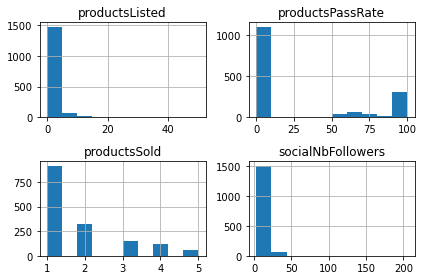

In [66]:
# Histograms for relevant variables in ultrasellers for comparison
ax = belowavg[ba_relev_vars].hist(bins=10)
plt.tight_layout()

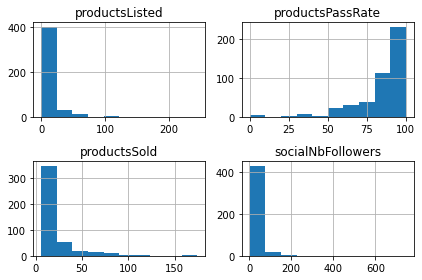

In [67]:
# Histograms for relevants variables in ultrasellers (productsSold >= 20)
ax = aboveavg[aa_relev_vars].hist(bins=10)
plt.tight_layout()

(array([1, 2, 3, 4]),
 [Text(1, 0, 'productsSold'),
  Text(2, 0, 'socialNbFollowers'),
  Text(3, 0, 'productsListed'),
  Text(4, 0, 'productsPassRate')])

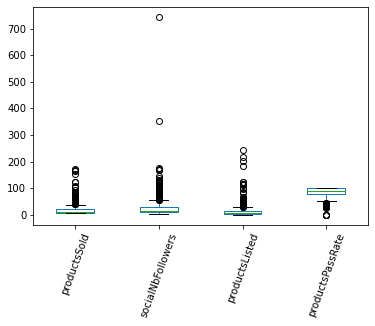

In [68]:
#Boxplots for ultrasellers
aboveavg[aa_relev_vars].plot(kind='box')
plt.xticks(rotation=70)

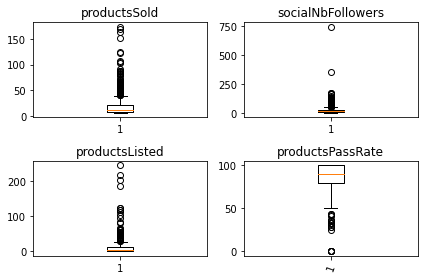

In [69]:
# For cleaner boxplots
fig, axes = plt.subplots(2,2)
for ax, var in zip(axes.ravel(), aa_relev_vars):
    ax.boxplot(aboveavg[var])
    ax.set_title(var)
    plt.xticks(rotation=70)
plt.tight_layout()

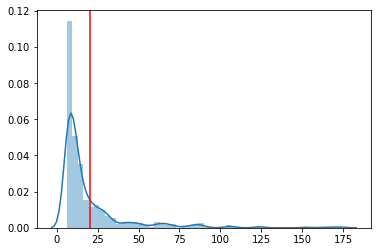

In [70]:
# Let's compare each 4 vars in lesser and ultra sellers with distplots. Ultra is blue, lesser is red.
# productsSold
mean = aboveavg['productsSold'].mean()
mean

x = aboveavg['productsSold'].values

sns.distplot(x)

plt.axvline(mean,0, 1, color = 'red')

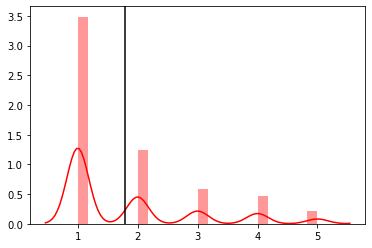

In [71]:
# Investigating the distribution of productsSold for lessersellers
x = belowavg['productsSold'].values

# Calculating the mean
mean = belowavg['productsSold'].mean()

sns.distplot(x, color='red')

# Plotting the mean

plt.axvline(mean,0, 1, color = 'black')

We see in this comparison that there IS a major difference in above average and below average sellers in the mean amount of items sold. On average, above average sellers sell closer to 24 items on average, but most sell closer to 10. Newer/less experienced sellers sell close to 2 items on average, but most sell just one item.

In [72]:
# socialNbFollowers

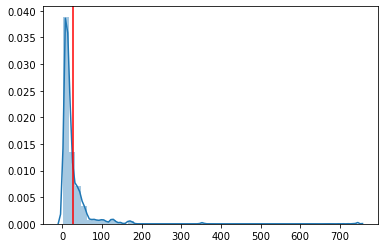

In [73]:
mean = aboveavg['socialNbFollowers'].mean()
mean

x = aboveavg['socialNbFollowers'].values

sns.distplot(x)

plt.axvline(mean,0, 1, color = 'red')

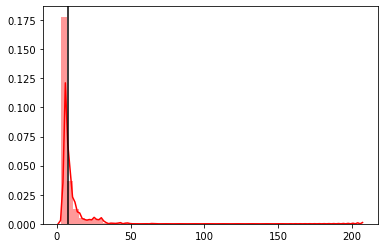

In [74]:
x = belowavg['socialNbFollowers'].values

# Calculating the mean
mean = belowavg['socialNbFollowers'].mean()

sns.distplot(x, color='red')

# Plotting the mean

plt.axvline(mean,0, 1, color = 'black')

Here is another largely observed difference between the two kinds of sellers. More experienced sellers have more followers on average.

Text(0.5, 1.0, 'Top Seller Product Listings')

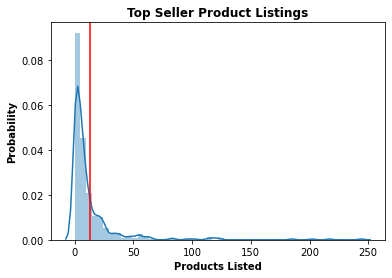

In [75]:
# productsListed
mean = aboveavg['productsListed'].mean()
mean

x = aboveavg['productsListed'].values

sns.distplot(x)

plt.axvline(mean,0, 1, color = 'red')

plt.xlabel('Products Listed', fontweight='bold')
plt.ylabel('Probability', fontweight='bold')
plt.title('Top Seller Product Listings', fontweight='bold')

# plt.savefig('toplistings.png')

Text(0.5, 1.0, 'Everyday Seller Product Listings')

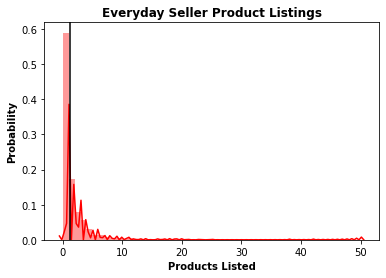

In [76]:
x = belowavg['productsListed'].values

# Calculating the mean
mean = belowavg['productsListed'].mean()

sns.distplot(x, color='red')

# Plotting the mean

plt.axvline(mean,0, 1, color = 'black')

plt.xlabel('Products Listed', fontweight='bold')
plt.ylabel('Probability', fontweight='bold')
plt.title('Everyday Seller Product Listings', fontweight='bold')


# plt.savefig('everydaylistings.png')

Unsurprisingly, most top sellers list closer to 10 items, where the everyday seller will tend to list only 1 item at any given time. This is understandable; especially as a newer seller, they may not have the confidence to list more than one item, just to see how it goes. But, the number of aboveavg sellers needs to increase over time. Vestiaire needs to instill that confidence in sellers, perhaps by making certain promotions for those who sell several items at a time? They would certainly gain much more attention.

Text(0.5, 1.0, 'Top Seller PPR')

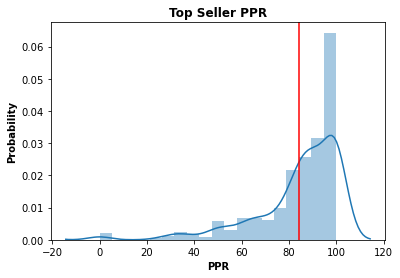

In [77]:
# productsPassRate
mean = aboveavg['productsPassRate'].mean()
mean

x = aboveavg['productsPassRate'].values

sns.distplot(x)

plt.axvline(mean,0, 1, color = 'red')

plt.xlabel('PPR', fontweight='bold')
plt.ylabel('Probability', fontweight='bold')
plt.title('Top Seller PPR', fontweight='bold')

# plt.savefig('highpassrate.png')

Text(0.5, 1.0, 'Everyday Seller PPR')

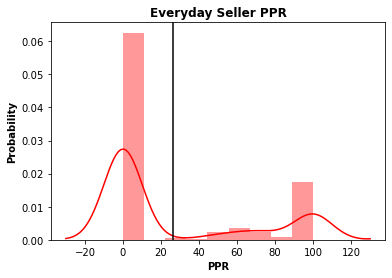

In [78]:
x = belowavg['productsPassRate'].values

# Calculating the mean
mean = belowavg['productsPassRate'].mean()

sns.distplot(x, color='red')

# Plotting the mean

plt.axvline(mean,0, 1, color = 'black')

plt.xlabel('PPR', fontweight='bold')
plt.ylabel('Probability', fontweight='bold')
plt.title('Everyday Seller PPR', fontweight='bold')

# plt.savefig('lowpassrate.png')

Okay, so this is ABSOLUTELY what I was curious about. If you want to be a top seller and make more sales, it's all about trust. The productsPassRate is the percentage of products meeting the product description for a given user. As we can see, above average sellers have largely better pass rates, meaning they take care to be honest in their descriptions. Below average sellers, who largely sell one item and leave, aren't as meticulous in their descriptions.

In [79]:
# topsellers

In [80]:
topsellers.sort_values(by=['sellers', 'topsellers'], ascending=False)

,eng_country,sellers,topsellers,topsellerratio,femalesellersratio,topfemalesellersratio,femalesellers,malesellers,topfemalesellers,topmalesellers,countrysoldratio,bestsoldratio,toptotalproductssold,totalproductssold,toptotalproductslisted,totalproductslisted,topmeanproductssold,topmeanproductslisted,meanproductssold,meanproductslisted,meanofflinedays,topmeanofflinedays,meanfollowers,meanfollowing,topmeanfollowers,topmeanfollowing
18,France,713,25,3.5,73.4,80.0,523,190,20,5,1.59,1.40,1109,3014,792,1892,44.360000,31.680000,4.227209,2.653576,227.1,36.6,8.9,28.3,41.3,156.2
9,Italy,347,35,10.1,71.5,65.7,248,99,23,12,1.27,1.29,1389,2820,1077,2218,39.685714,30.771429,8.126801,6.391931,141.8,26.5,16.1,54.6,63.4,429.3
13,United Kingdom,289,21,7.3,80.3,85.7,232,57,18,3,1.95,2.16,972,1806,449,927,46.285714,21.380952,6.249135,3.207612,188.1,32.4,10.1,8.8,37.3,9.1
16,United States,150,6,4.0,78.7,83.3,118,32,5,1,1.19,1.30,558,967,428,816,93.000000,71.333333,6.446667,5.440000,266.1,76.8,14.6,10.2,105.0,17.2
8,Spain,119,13,10.9,81.5,76.9,97,22,10,3,1.67,2.02,607,990,301,594,46.692308,23.153846,8.319328,4.991597,202.4,30.5,16.1,14.6,53.2,14.5
15,Germany,105,5,4.8,75.2,80.0,79,26,4,1,2.03,2.85,282,536,99,264,56.400000,19.800000,5.104762,2.514286,168.2,79.4,10.7,8.8,53.2,10.6
17,Netherlands,54,2,3.7,77.8,50.0,42,12,1,1,1.54,1.74,47,214,27,139,23.500000,13.500000,3.962963,2.574074,177.4,22.0,11.4,9.6,21.5,10.0
12,Sweden,32,3,9.4,81.3,66.7,26,6,2,1,1.45,1.29,202,336,156,231,67.333333,52.000000,10.500000,7.218750,118.2,12.7,19.8,24.0,102.7,172.0
14,Austria,18,1,5.6,77.8,100.0,14,4,1,0,1.81,1.00,20,67,20,37,20.000000,20.000000,3.722222,2.055556,138.7,11.0,7.0,8.6,17.0,10.0
6,Romania,13,2,15.4,76.9,50.0,10,3,1,1,0.88,1.26,49,68,39,77,24.500000,19.500000,5.230769,5.923077,121.6,11.0,10.9,11.5,30.0,32.0


Unsurprisingly, the countries with the most sellers, and the most top sellers (>= 20 products sold) exist in the fashion capitals of the world (France, Italy, UK, and US). We can surmise these refer to Paris, Milan, London, and New York.
In each country, there are more female than male sellers, and more female topsellers than male topsellers. These countries also lead in terms of sales. Is there a correlation between seller country and sales?

In [81]:
# Sales by Country

In [82]:
# inactive_u

In [83]:
do_better = inactive_u.groupby(['eng_country'])['identifierHash'].count().reset_index()
do_better.sort_values('identifierHash', ascending=False)

,eng_country,identifierHash
64,France,20159
186,United States,16668
185,United Kingdom,8753
90,Italy,6020
68,Germany,4732
...,...,...
59,Ethiopia,1
150,Rwanda,1
60,Falkland Islands,1
70,Gibraltar,1


In [84]:
# Active users by country to compare with inactive.
most_active = active_clean.groupby(['eng_country'])['identifierHash'].count().reset_index()
most_active.sort_values('identifierHash', ascending=False)

,eng_country,identifierHash
42,France,4970
124,United States,3926
123,United Kingdom,2555
60,Italy,1993
45,Germany,1834
...,...,...
104,Samoa,1
49,Guam,1
46,Ghana,1
43,Gabon,1


In [85]:
# Finally, seeing total users by country just to make sure I have the whole picture.
most_totalu = users_c.groupby(['eng_country'])['identifierHash'].count().reset_index()
most_totalu.sort_values('identifierHash', ascending=False)

,eng_country,identifierHash
64,France,25129
188,United States,20594
187,United Kingdom,11308
91,Italy,8013
68,Germany,6566
...,...,...
169,St Barthélémy,1
170,Suriname,1
171,Svalbard and Jan Mayen Islands,1
140,Palau,1


France, US, UK, Italy, and Germany are the top five countries in regards to total users. This same order holds, proportionally, for both active and inactive users. Because of this proportionality, it makes sense that the top spoken language for active users is English. 

As far as sales though, this order is slightly different. France, Italy, UK, Spain, and US are in the top spots. Germany comes next, but has quite a bit less sales than the US (by 454 sales).

# Univariate-Numeric Visualizations

Excluding users['identifierHash'] as it hugely skews visualizations, and serves only as a unique identifier. Discovering relationships is tricky, as there are 10 numeric vbls to work with.

In [86]:
# Using .describe() automatically identifies numerical columns for you.

In [87]:
active_clean.describe()

,identifierHash,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsSold,productsPassRate,productsWished,productsBought,daysSinceLastLogin,seniorityAsYears
count,2.163900e+04,21639.000000,21639.000000,21639.000000,21639.000000,21639.000000,21639.000000,21639.000000,21639.000000,21639.000000,21639.000000
mean,3.526222e+16,4.557558,9.911271,20.207450,0.426498,0.555802,3.713078,7.142705,0.785896,384.445631,8.510885
std,5.329057e+18,8.155680,112.960063,386.638353,4.367049,4.520774,17.874985,53.491932,4.937857,271.408591,0.467789
min,-9.220000e+18,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,11.000000,7.920000
25%,-4.540000e+18,3.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,87.000000,7.940000
50%,6.320000e+16,3.000000,8.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,401.000000,8.880000
75%,4.630000e+18,4.000000,8.000000,6.000000,0.000000,0.000000,0.000000,2.000000,1.000000,680.000000,8.890000
max,9.220000e+18,744.000000,13764.000000,51671.000000,244.000000,174.000000,100.000000,2635.000000,405.000000,709.000000,8.900000


In [88]:
# Excluding identifierHash, as an identifier won't have any particular relevance to analysis.
ac_numeric_vars = ['socialNbFollowers', 'socialNbFollows',
                  'socialProductsLiked', 'productsListed', 'productsSold',
                  'productsPassRate', 'productsWished', 'productsBought', 
                   'daysSinceLastLogin', 'seniorityAsYears']

ac_categorical_vars = ['eng_country', 'language', 'gender', 
                      'hasAnyApp','hasAndroidApp', 'hasIosApp', 'hasProfilePicture']

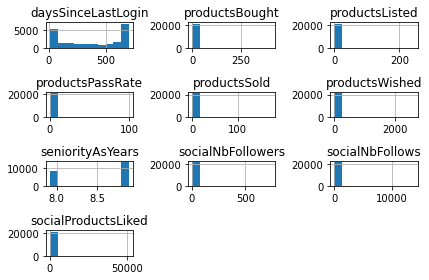

In [89]:
# Histograms
# sns.set(rc={'figure.figsize': (16,3)})

ax = active_clean[ac_numeric_vars].hist(bins=10)
plt.tight_layout()

It looks like with the exception of a few shops, most sellers sell about the same number of products.

# Numeric vs Numeric Viz

In [90]:
# Creating new df w/ only the numerical vars
num_df = active_clean[['socialNbFollowers',
                  'productsListed', 'productsSold',
                  'productsPassRate']]
num_df

,socialNbFollowers,productsListed,productsSold,productsPassRate
0,147,26,174,74.0
1,167,19,170,99.0
2,137,33,163,94.0
3,131,122,152,92.0
4,167,25,125,100.0
...,...,...,...,...
21634,3,0,0,0.0
21635,3,0,0,0.0
21636,3,0,0,0.0
21637,3,0,0,0.0


In [91]:
# Correlation Matrix

def heatmap(x, y, **kwargs):
    if 'color' in kwargs:
        color = kwargs['color']
    else:
        color = [1]*len(x)

    if 'palette' in kwargs:
        palette = kwargs['palette']
        n_colors = len(palette)
    else:
        n_colors = 256 # Use 256 colors for the diverging color palette
        palette = sns.color_palette("Blues", n_colors) 

    if 'color_range' in kwargs:
        color_min, color_max = kwargs['color_range']
    else:
        color_min, color_max = min(color), max(color) # Range of values that will be mapped to the palette, i.e. min and max possible correlation

    def value_to_color(val):
        if color_min == color_max:
            return palette[-1]
        else:
            val_position = float((val - color_min)) / (color_max - color_min) # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            ind = int(val_position * (n_colors - 1)) # target index in the color palette
            return palette[ind]

    if 'size' in kwargs:
        size = kwargs['size']
    else:
        size = [1]*len(x)

    if 'size_range' in kwargs:
        size_min, size_max = kwargs['size_range'][0], kwargs['size_range'][1]
    else:
        size_min, size_max = min(size), max(size)

    size_scale = kwargs.get('size_scale', 500)

    def value_to_size(val):
        if size_min == size_max:
            return 1 * size_scale
        else:
            val_position = (val - size_min) * 0.99 / (size_max - size_min) + 0.01 # position of value in the input range, relative to the length of the input range
            val_position = min(max(val_position, 0), 1) # bound the position betwen 0 and 1
            return val_position * size_scale
    if 'x_order' in kwargs: 
        x_names = [t for t in kwargs['x_order']]
    else:
        x_names = [t for t in sorted(set([v for v in x]))]
    x_to_num = {p[1]:p[0] for p in enumerate(x_names)}

    if 'y_order' in kwargs: 
        y_names = [t for t in kwargs['y_order']]
    else:
        y_names = [t for t in sorted(set([v for v in y]))]
    y_to_num = {p[1]:p[0] for p in enumerate(y_names)}

    plot_grid = plt.GridSpec(1, 15, hspace=0.2, wspace=0.1) # Setup a 1x10 grid
    ax = plt.subplot(plot_grid[:,:-1]) # Use the left 14/15ths of the grid for the main plot

    marker = kwargs.get('marker', 's')

    kwargs_pass_on = {k:v for k,v in kwargs.items() if k not in [
         'color', 'palette', 'color_range', 'size', 'size_range', 'size_scale', 'marker', 'x_order', 'y_order'
    ]}

    ax.scatter(
        x=[x_to_num[v] for v in x],
        y=[y_to_num[v] for v in y],
        marker=marker,
        s=[value_to_size(v) for v in size], 
        c=[value_to_color(v) for v in color],
        **kwargs_pass_on
    )
    ax.set_xticks([v for k,v in x_to_num.items()])
    ax.set_xticklabels([k for k in x_to_num], rotation=45, horizontalalignment='right')
    ax.set_yticks([v for k,v in y_to_num.items()])
    ax.set_yticklabels([k for k in y_to_num])

    ax.grid(False, 'major')
    ax.grid(True, 'minor')
    ax.set_xticks([t + 0.5 for t in ax.get_xticks()], minor=True)
    ax.set_yticks([t + 0.5 for t in ax.get_yticks()], minor=True)

    ax.set_xlim([-0.5, max([v for v in x_to_num.values()]) + 0.5])
    ax.set_ylim([-0.5, max([v for v in y_to_num.values()]) + 0.5])
    ax.set_facecolor('#F1F1F1')

    # Add color legend on the right side of the plot
    if color_min < color_max:
        ax = plt.subplot(plot_grid[:,-1]) # Use the rightmost column of the plot

        col_x = [0]*len(palette) # Fixed x coordinate for the bars
        bar_y=np.linspace(color_min, color_max, n_colors) # y coordinates for each of the n_colors bars

        bar_height = bar_y[1] - bar_y[0]
        ax.barh(
            y=bar_y,
            width=[5]*len(palette), # Make bars 5 units wide
            left=col_x, # Make bars start at 0
            height=bar_height,
            color=palette,
            linewidth=0
        )
        ax.set_xlim(1, 2) # Bars are going from 0 to 5, so lets crop the plot somewhere in the middle
        ax.grid(False) # Hide grid
        ax.set_facecolor('white') # Make background white
        ax.set_xticks([]) # Remove horizontal ticks
        ax.set_yticks(np.linspace(min(bar_y), max(bar_y), 3)) # Show vertical ticks for min, middle and max
        ax.yaxis.tick_right() # Show vertical ticks on the right 


def corrplot(data, size_scale=500, marker='s'):
    corr = pd.melt(data.reset_index(), id_vars='index')
    corr.columns = ['x', 'y', 'value']
    heatmap(
        corr['x'], corr['y'],
        color=corr['value'], color_range=[-1, 1],
        palette=sns.diverging_palette(20, 220, n=256),
        size=corr['value'].abs(), size_range=[0,1],
        marker=marker,
        x_order=data.columns,
        y_order=data.columns[::-1],
        size_scale=size_scale
    )

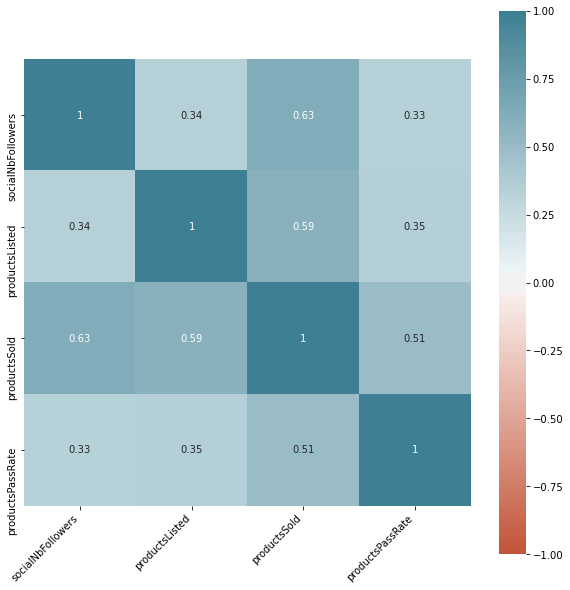

In [92]:
%matplotlib inline
data = num_df

corr = data.corr()
plt.figure(figsize=(10, 10))
ax = sns.heatmap(
    corr, 
    annot=True,
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

# plt.savefig('corrmatrix.png')

As far as predicting how many products will be sold from any given seller, socialNbFollowers, productsListed, and productsPassRate matter the most. The strongest correlation is obviously productsSold with itself. Granted, the more products you do sell, the more likely you are to continue selling. *BUT BE CAREFUL* when modeling. NEVER include the variable you're measuring against itself for risk of data leakage!

socialNbFollows, socialProductsLiked, productsWished, and productsBought MAY have some sort of correlation, but this is most impactful on buyers, not sellers.

Let's inspect these relationships further

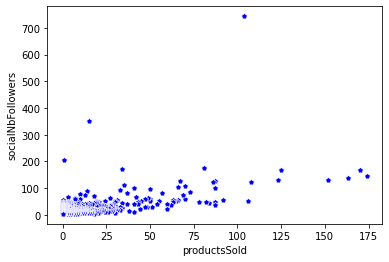

In [93]:
ax = sns.scatterplot(x = 'productsSold' , y = 'socialNbFollowers', data = num_df, color = 'blue', marker = "p")

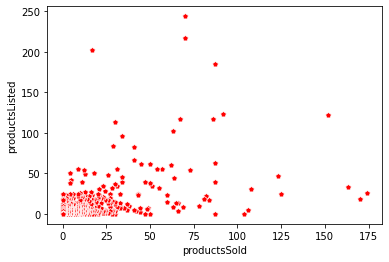

In [94]:
ax = sns.scatterplot(x = 'productsSold' , y = 'productsListed', data = num_df, color = 'red', marker = "p")

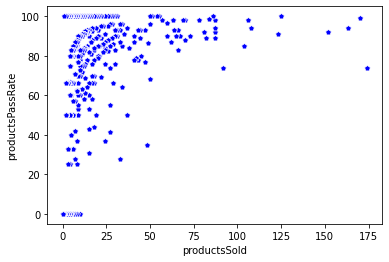

In [95]:
ax = sns.scatterplot(x = 'productsSold' , y = 'productsPassRate', data = num_df, color = 'blue', marker = "p")

In [96]:
# sellers
# Remember, these are successful sellers who have > 1 products sold, and are active

In [97]:
sellers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2036 entries, 0 to 2035
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   identifierHash       2036 non-null   float64
 1   eng_country          2036 non-null   object 
 2   language             2036 non-null   object 
 3   socialNbFollowers    2036 non-null   int64  
 4   socialNbFollows      2036 non-null   int64  
 5   socialProductsLiked  2036 non-null   int64  
 6   productsListed       2036 non-null   int64  
 7   productsSold         2036 non-null   int64  
 8   productsPassRate     2036 non-null   float64
 9   productsWished       2036 non-null   int64  
 10  productsBought       2036 non-null   int64  
 11  gender               2036 non-null   object 
 12  hasAnyApp            2036 non-null   bool   
 13  hasAndroidApp        2036 non-null   bool   
 14  hasIosApp            2036 non-null   bool   
 15  hasProfilePicture    2036 non-null   b

In [98]:
sellers.describe()

,identifierHash,socialNbFollowers,socialNbFollows,socialProductsLiked,productsListed,productsSold,productsPassRate,productsWished,productsBought,daysSinceLastLogin,seniorityAsYears
count,2.036000e+03,2036.000000,2036.000000,2036.000000,2036.000000,2036.000000,2036.000000,2036.000000,2036.000000,2036.000000,2036.000000
mean,1.215730e+17,11.848723,24.544204,70.349705,3.973477,5.907171,39.463310,18.294204,2.439096,190.700393,8.510368
std,5.294699e+18,24.246375,367.788293,1183.479716,13.663211,13.626529,44.563032,108.396766,13.971495,226.993545,0.468338
min,-9.220000e+18,3.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,11.000000,7.920000
25%,-4.480000e+18,4.000000,8.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,14.000000,7.940000
50%,2.475000e+17,6.000000,8.000000,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,58.500000,8.880000
75%,4.555000e+18,11.000000,9.000000,12.000000,3.000000,5.000000,91.000000,2.000000,1.000000,346.000000,8.890000
max,9.200000e+18,744.000000,13764.000000,51671.000000,244.000000,174.000000,100.000000,1916.000000,405.000000,709.000000,8.900000


In [99]:
# topsellers
# Remember, these are stats about countries with top sellers. Top sellers have >= 20 products sold
# They represent the top ~10% of all seller accounts in the dataset

In [100]:
topsellers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19 entries, 0 to 18
Data columns (total 26 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   eng_country             19 non-null     object 
 1   sellers                 19 non-null     int64  
 2   topsellers              19 non-null     int64  
 3   topsellerratio          19 non-null     float64
 4   femalesellersratio      19 non-null     float64
 5   topfemalesellersratio   19 non-null     float64
 6   femalesellers           19 non-null     int64  
 7   malesellers             19 non-null     int64  
 8   topfemalesellers        19 non-null     int64  
 9   topmalesellers          19 non-null     int64  
 10  countrysoldratio        19 non-null     float64
 11  bestsoldratio           18 non-null     float64
 12  toptotalproductssold    19 non-null     int64  
 13  totalproductssold       19 non-null     int64  
 14  toptotalproductslisted  19 non-null     int6

In [101]:
topsellers.describe()

,sellers,topsellers,topsellerratio,femalesellersratio,topfemalesellersratio,femalesellers,malesellers,topfemalesellers,topmalesellers,countrysoldratio,bestsoldratio,toptotalproductssold,totalproductssold,toptotalproductslisted,totalproductslisted,topmeanproductssold,topmeanproductslisted,meanproductssold,meanproductslisted,meanofflinedays,topmeanofflinedays,meanfollowers,meanfollowing,topmeanfollowers,topmeanfollowing
count,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,18.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000,19.000000
mean,99.578947,6.631579,20.968421,78.778947,80.963158,75.368421,24.210526,5.105263,1.526316,2.032632,1.960556,309.105263,610.631579,196.157895,401.157895,50.026688,30.124714,12.966926,8.582865,122.631579,23.757895,19.752632,17.389474,55.310526,56.389474
std,178.948570,9.804820,24.430174,22.167182,26.052025,131.976097,47.390317,7.194865,2.874571,1.616621,1.839704,419.088415,933.298524,296.793281,645.312092,34.374679,19.263995,13.502800,12.208144,73.153940,20.889453,17.128448,14.551552,36.883012,103.303425
min,1.000000,1.000000,3.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.690000,0.620000,20.000000,28.000000,0.000000,8.000000,20.000000,0.000000,3.722222,1.142857,11.000000,11.000000,7.000000,8.000000,15.000000,3.000000
25%,6.000000,1.000000,6.450000,74.300000,71.800000,5.500000,0.500000,1.000000,0.000000,1.230000,1.267500,44.000000,62.000000,31.000000,46.000000,28.500000,18.500000,5.167766,2.930594,62.600000,11.000000,10.800000,8.700000,36.650000,8.550000
50%,13.000000,2.000000,10.100000,78.700000,85.700000,10.000000,3.000000,1.000000,1.000000,1.590000,1.425000,81.000000,170.000000,56.000000,81.000000,41.000000,21.380952,8.126801,5.500000,121.600000,12.700000,15.100000,10.200000,46.300000,14.500000
75%,112.000000,5.500000,22.500000,92.850000,100.000000,88.000000,24.000000,4.500000,1.000000,2.015000,2.080000,420.000000,751.500000,228.500000,429.000000,56.700000,39.500000,14.000000,7.109375,172.800000,28.500000,20.400000,19.750000,58.300000,36.500000
max,713.000000,35.000000,100.000000,100.000000,100.000000,523.000000,190.000000,23.000000,12.000000,7.310000,8.950000,1389.000000,3014.000000,1077.000000,2218.000000,170.000000,71.333333,57.000000,56.000000,266.100000,79.400000,83.000000,54.600000,167.000000,429.300000


# Regression Model

How can we get an idea on what a given seller's lifetime value will be? Let's try to predict productsSold using other variables (regression task). We will be making a multiple linear regression model using 'sellers' so that we can focus on users who have made at least one sale.

Train-test-split is used to estimate the performance of machine learning algorithms when they are used to make predictions on data not used to train the model.

In [102]:
def statsmodels_train_test_split(df, random_state=42, stratify=None, **kwargs):

    if stratify is None:
        y, X = df.iloc[:,0], df.drop(columns=df.columns[0])
        X_train, X_test, y_train, y_test = train_test_split(X,y, **kwargs)
    else:
        y, X = stratify, df.drop(columns = stratify.name)
        X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y, **kwargs)
    
    return pd.concat([X_train, y_train], axis=1), pd.concat([X_test, y_test], axis=1)

In [103]:
train, test = statsmodels_train_test_split(sellers)

<AxesSubplot:xlabel='productsSold'>

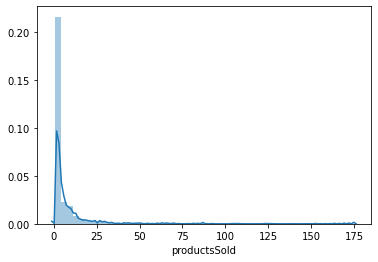

In [104]:
sns.distplot(sellers['productsSold'])

Performing a linear regression assumes that the dependent variable is distributed as a normal random variable. The R^2 will let us know how much of our data the model explains.

We will be predicting products sold based on the following correlated variables: socialNbFollowers, productsListed, and productsPassRate.

In [105]:
formula = 'productsSold ~ socialNbFollowers + productsListed + productsPassRate'
lm = smf.ols(formula=formula, data=train).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           productsSold   R-squared:                       0.578
Model:                            OLS   Adj. R-squared:                  0.578
Method:                 Least Squares   F-statistic:                     696.3
Date:                Tue, 06 Oct 2020   Prob (F-statistic):          5.94e-285
Time:                        10:47:16   Log-Likelihood:                -5572.5
No. Observations:                1527   AIC:                         1.115e+04
Df Residuals:                    1523   BIC:                         1.117e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            -0.8252      0.326     -2.532      0.011      -1.464      -0.186
socialNbFollowers     0.2346      0.009     24.893      0.000       0.216       0.253
productsListed        0.5295      0.023     23.408      0.000       0.485       0.574
productsPassRate      0.0501      0.006      8.883      0.000       0.039       0.061
==============================================================================
Omnibus:                     1604.444   Durbin-Watson:                   1.937
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           267207.897
Skew:                           4.707   Prob(JB):                         0.00
Kurtosis:                      67.118   Cond. No.                         83.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [106]:
y_test_pred = lm.predict(test)
y_test_pred

1430     0.582436
1770     0.113240
825      3.518226
752      8.536446
24      34.882740
          ...    
1165     3.813133
593      7.946632
1523     0.347838
631      6.713335
86      18.951335
Length: 509, dtype: float64

In [107]:
r2_score(test['productsSold'], y_test_pred)

0.26793966305941597

In [108]:
mean_squared_error(test['productsSold'], y_test_pred)

92.5634675457378